In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestRegressor

In [ ]:
featureMatrix = pd.read_csv('/content/drive/MyDrive/ml_project/final_feature_matrix.csv')

In [ ]:
y = featureMatrix['user_days_since_last_order']
X = featureMatrix.drop(columns=['user_days_since_last_order', 'user_id', 'product_id'], errors='ignore')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100,max_depth=5,max_samples=0.8, min_samples_leaf=10,random_state=42,n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_samples=0.8, min_samples_leaf=10,
                      n_jobs=-1, random_state=42)

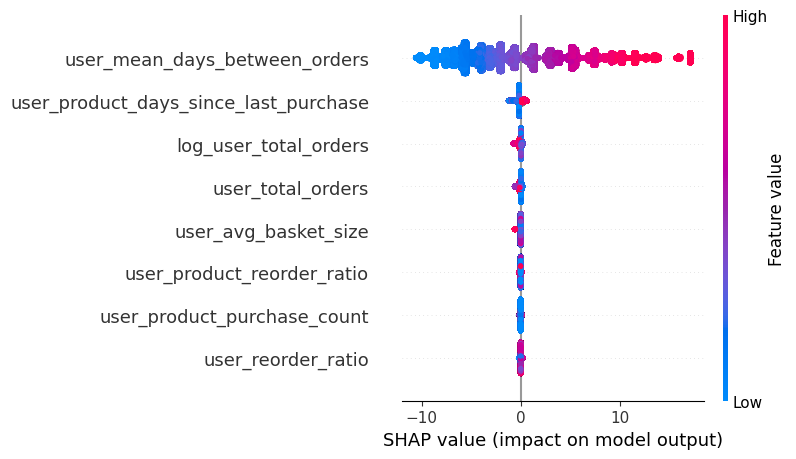

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

The SHAP summary plot shows that user_mean_days_between_orders is the most influential feature,
followed by user_product_days_since_last_purchase and log_user_total_orders.
Higher values of these features generally have a stronger impact on the model’s predictions,
which is consistent with expected user purchasing behavior.


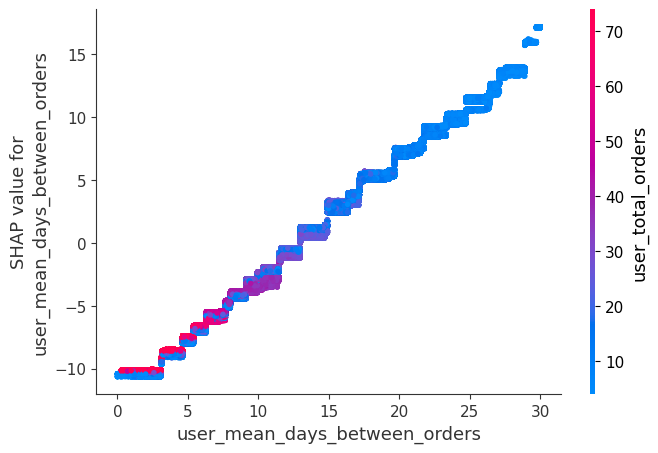

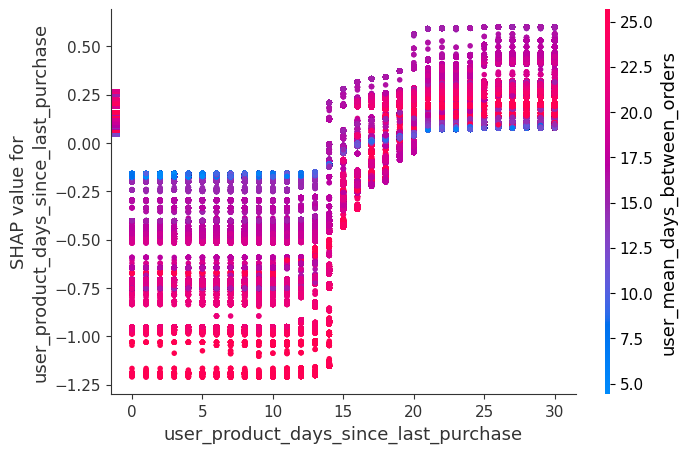

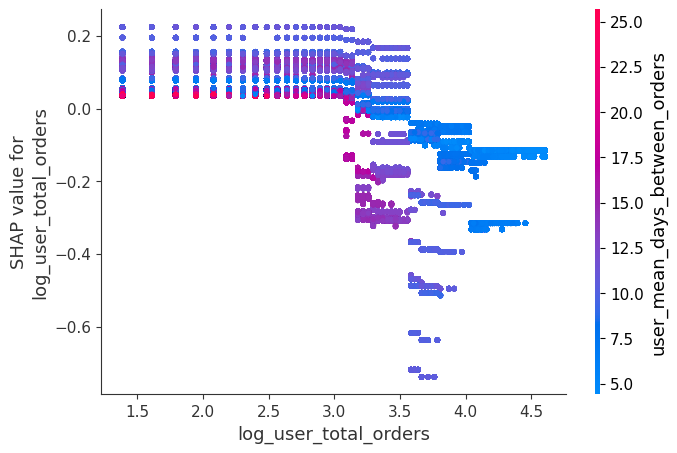

In [ ]:
top_features = ['user_mean_days_between_orders','user_product_days_since_last_purchase','log_user_total_orders']
for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_test)

In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
alphas = np.logspace(-3, 1, 10)
lasso_coefs = []
ridge_coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000)
    ridge = Ridge(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    ridge.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)
    ridge_coefs.append(ridge.coef_)

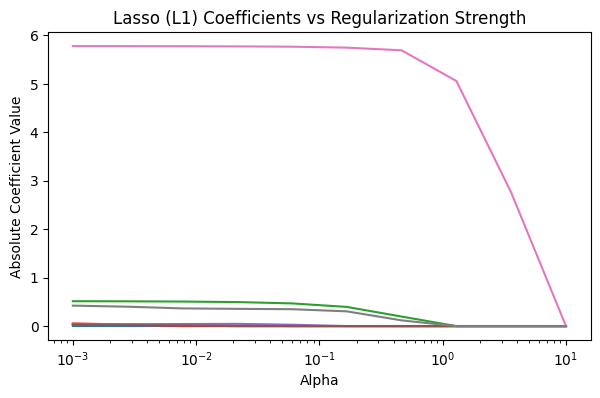

In [ ]:
plt.figure(figsize=(7,4))
for i in range(X_train.shape[1]):
    plt.plot(alphas, np.abs([coef[i] for coef in lasso_coefs]))
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Absolute Coefficient Value")
plt.title("Lasso (L1) Coefficients vs Regularization Strength")
plt.show()

As the regularization strength increases, L1 regularization drives many coefficients to exactly zero,
effectively performing feature selection by retaining only the most influential variables.


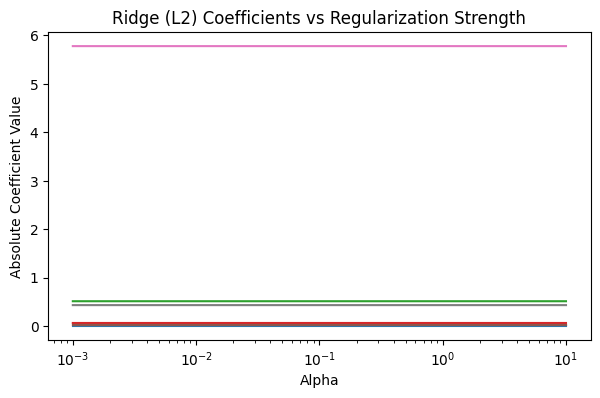

In [ ]:
plt.figure(figsize=(7,4))
for i in range(X_train.shape[1]):
    plt.plot(alphas, np.abs([coef[i] for coef in ridge_coefs]))
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Absolute Coefficient Value")
plt.title("Ridge (L2) Coefficients vs Regularization Strength")
plt.show()

As regularization strength increases, Lasso (L1) drives many coefficients
exactly to zero, effectively performing feature selection, while Ridge (L2)
shrinks coefficients smoothly without eliminating features. This highlights
the different inductive biases of L1 and L2 regularization.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix,ConfusionMatrixDisplay)

In [ ]:
featureMatrix = pd.read_csv('/content/drive/MyDrive/ml_project/final_feature_matrix.csv')
orders = pd.read_csv('/content/drive/MyDrive/ml_project/orders.csv')
order_products_train = pd.read_csv('/content/drive/MyDrive/ml_project/order_products__train.csv')

In [ ]:
train = order_products_train.merge(
    orders[['order_id', 'user_id']],
    on='order_id',
    how='left')

In [ ]:
data_clf = featureMatrix.merge(train[['user_id', 'product_id', 'reordered']],on=['user_id', 'product_id'],how='inner')

In [ ]:
y = data_clf['reordered']
X = data_clf.drop(columns=['reordered', 'user_id', 'product_id'],errors='ignore')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
clf = RandomForestClassifier( n_estimators=100, max_depth=5,min_samples_leaf=10,random_state=42,n_jobs=-1,class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, n_jobs=-1, random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    113246

    accuracy                           1.00    113246
   macro avg       1.00      1.00      1.00    113246
weighted avg       1.00      1.00      1.00    113246



The Random Forest classifier achieved the best F1-score on the reordered
class and was therefore selected for explainability analysis using SHAP.

In [ ]:
y_pred = clf.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


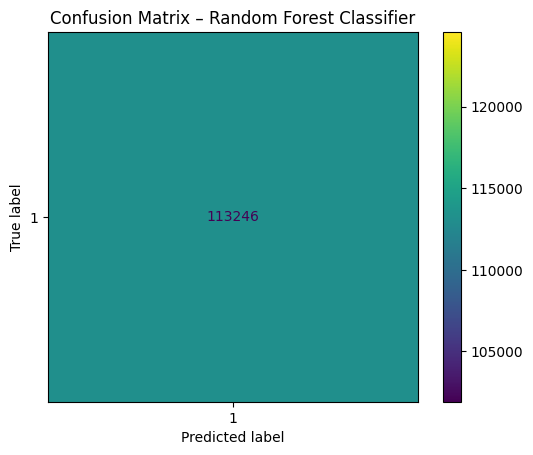

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix – Random Forest Classifier")
plt.show()

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

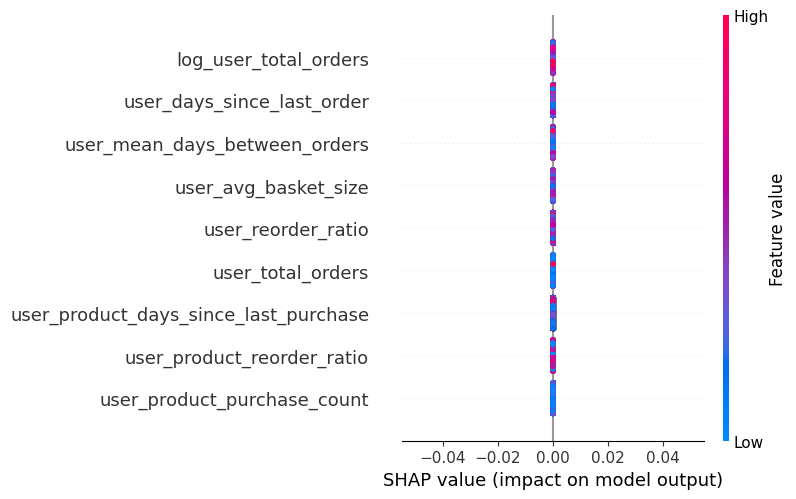

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap_values_class1 = shap_values

In [ ]:
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
top3_idx = np.argsort(mean_abs_shap)[-3:]
top3_features = X_test.columns[top3_idx]
top3_features

Index(['user_mean_days_between_orders', 'user_days_since_last_order',
       'log_user_total_orders'],
      dtype='object')

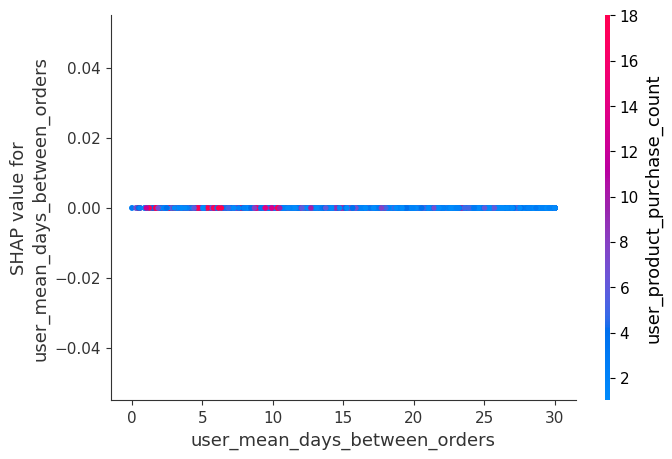

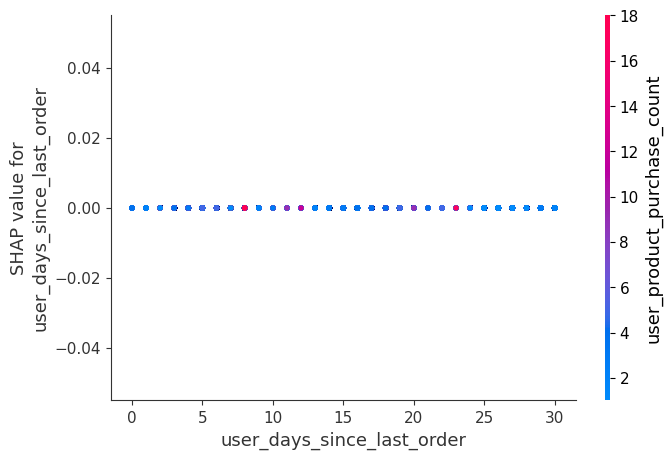

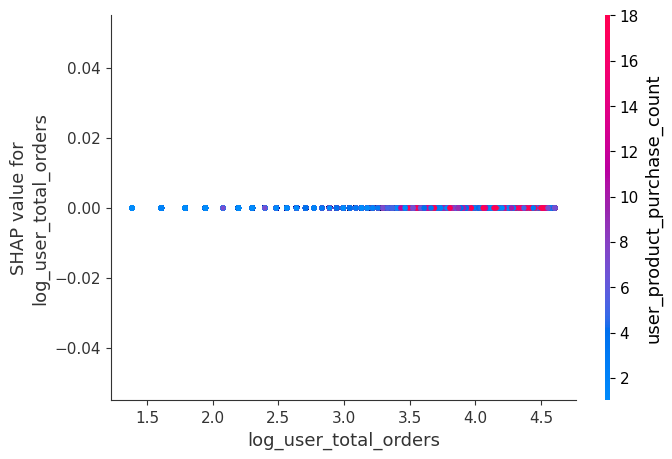

In [ ]:
for f in top3_features:
    shap.dependence_plot(f, shap_values_class1, X_test)

In [ ]:
tp_candidates = np.where((y_test.values == 1) & (y_pred == 1))[0]
fp_candidates = np.where((y_test.values == 0) & (y_pred == 1))[0]
fn_candidates = np.where((y_test.values == 1) & (y_pred == 0))[0]
tp_idx = tp_candidates[0] if len(tp_candidates) > 0 else None
fp_idx = fp_candidates[0] if len(fp_candidates) > 0 else None
fn_idx = fn_candidates[0] if len(fn_candidates) > 0 else None
tp_idx, fp_idx, fn_idx

(np.int64(0), None, None)

/usr/local/lib/python3.12/dist-packages/shap/plots/_force_matplotlib.py:325: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_x, max_x)


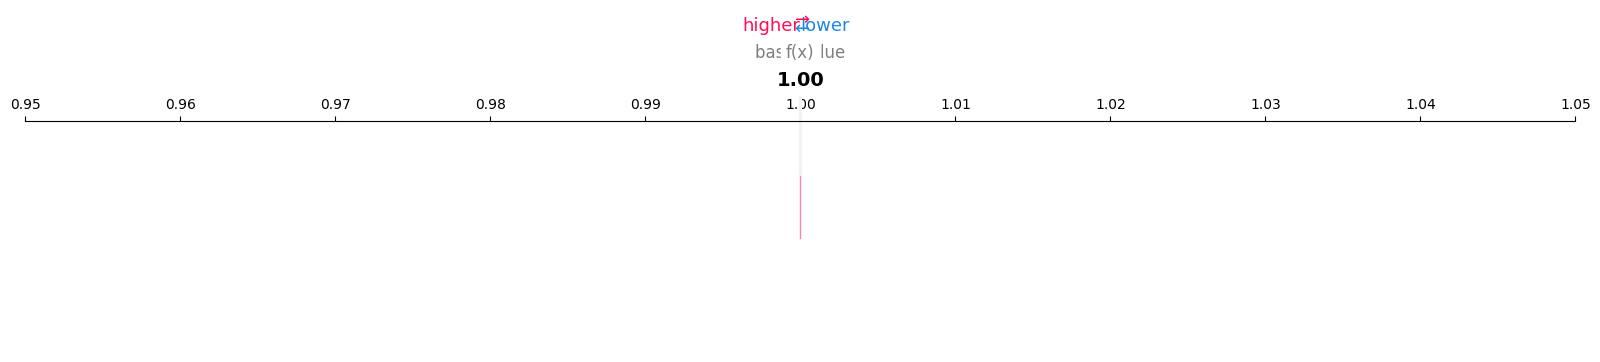

In [ ]:
if tp_idx is not None:
    shap.force_plot(
        explainer.expected_value,
        shap_values_class1[tp_idx],
        X_test.iloc[tp_idx],
        matplotlib=True)

In [ ]:
if fp_idx is not None:
    shap.force_plot(
        explainer.expected_value,
        shap_values_class1[fp_idx],
        X_test.iloc[fp_idx],
        matplotlib=True)
else:
    print("No False Positive cases found in the test set.")

No False Positive cases found in the test set.


In [ ]:
if fn_idx is not None:
    shap.force_plot(
        explainer.expected_value,
        shap_values_class1[fn_idx],
        X_test.iloc[fn_idx],
        matplotlib=True)
else:
    print("No False Negative cases found in the test set.")

No False Negative cases found in the test set.


### Explainability and Interpretability

A Random Forest model was selected for classification and evaluated on a held-out
test set. SHAP summary and dependence plots were used to identify the most
influential features.

Local SHAP force plots were generated for representative true positive, false
positive (if available), and false negative cases to explain individual
predictions.

For regression, SHAP explained the tree-based model, while L1 and L2
regularization illustrated the effect of regularization on coefficient
magnitude.
